
The data can be downloaded from
https://www.kaggle.com/datasets/atanaskanev/sqlite-sakila-sample-database

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# set figure size globally
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
DATABASE_PATH = './sqlite-sakila.db'

In [3]:
# create a connection
conn = sqlite3.connect(DATABASE_PATH)

tables = pd.read_sql("""
SELECT *
FROM sqlite_master
WHERE type = 'table';
""", conn)

# check the tables
tables

,type,name,tbl_name,rootpage,sql
0,table,actor,actor,2,CREATE TABLE actor (\n actor_id numeric NOT N...
1,table,country,country,5,CREATE TABLE country (\n country_id SMALLINT ...
2,table,city,city,7,"CREATE TABLE city (\n city_id int NOT NULL,\n..."
3,table,address,address,10,CREATE TABLE address (\n address_id int NOT N...
4,table,language,language,13,CREATE TABLE language (\n language_id SMALLIN...
5,table,category,category,15,CREATE TABLE category (\n category_id SMALLIN...
6,table,customer,customer,19,CREATE TABLE customer (\n customer_id INT NOT...
7,table,film,film,24,"CREATE TABLE film (\n film_id int NOT NULL,\n..."
8,table,film_actor,film_actor,28,CREATE TABLE film_actor (\n actor_id INT NOT ...
9,table,film_category,film_category,33,CREATE TABLE film_category (\n film_id INT NO...


### 1. Time-series plot for daily total revenue for custumers from three countries:

** Note that there are only two stores, so we cannot do daily total revenue for stores. **

In [4]:
query = f"""
SELECT strftime('%Y-%m-%d', p.payment_date) as date, co.country, SUM(p.amount) as daily_revenue 
FROM payment p
JOIN customer c ON p.customer_id = c.customer_id
JOIN address a ON c.address_id = a.address_id
JOIN city ci ON a.city_id = ci.city_id
JOIN country co ON ci.country_id = co.country_id
GROUP BY date, co.country
"""

df_filtered = pd.read_sql(query, conn)
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered

,date,country,daily_revenue
0,2005-05-24,Azerbaijan,4.99
1,2005-05-24,Brazil,2.99
2,2005-05-24,Indonesia,4.99
3,2005-05-24,Iran,2.99
4,2005-05-24,Russian Federation,6.99
...,...,...,...
2924,2006-02-14,United States,28.89
2925,2006-02-14,Venezuela,5.98
2926,2006-02-14,Vietnam,8.97
2927,2006-02-14,Yemen,2.99


In [5]:
# calculate total revenue
df_total_revenue = df_filtered.groupby("country")['daily_revenue'].sum().sort_values(ascending=False)

df_total_revenue = df_total_revenue.reset_index().rename(columns={'daily_revenue': 'total_revenue'})

In [6]:
df_total_revenue

,country,total_revenue
0,India,6630.27
1,China,5802.73
2,United States,4110.32
3,Japan,3471.74
4,Mexico,3307.04
...,...,...
103,Tunisia,78.77
104,Tonga,73.82
105,Lithuania,73.76
106,American Samoa,71.80


In [7]:
top3_countries = df_total_revenue['country'][0:3]

top3_countries

0            India
1            China
2    United States
Name: country, dtype: object

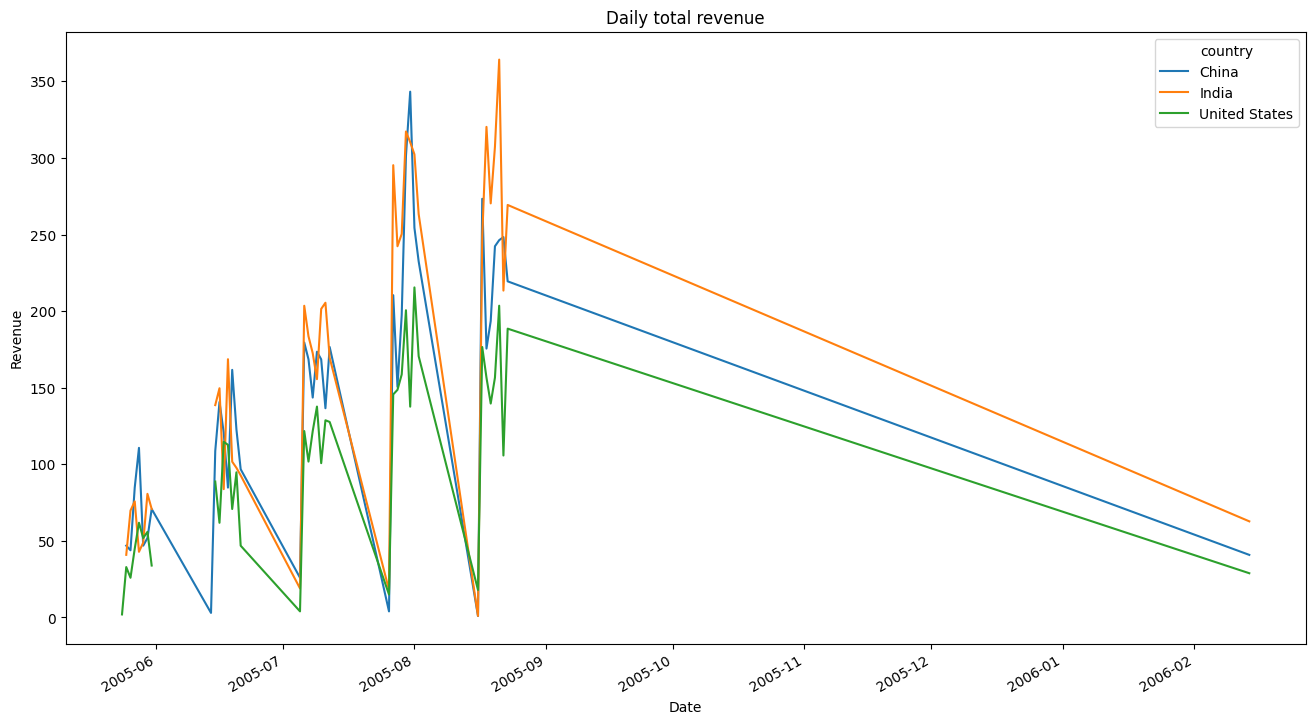

In [8]:
# choose top3 countries to plot daily revenue

# use of np.where and iloc
df_pivot = df_filtered.iloc[np.where(df_filtered['country'].isin(top3_countries))] \
                                 .pivot(index='date', columns='country', values='daily_revenue')
df_pivot.plot()
plt.title('Daily total revenue')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.show()

### 2. Sentiment Analysis

In [9]:
from textblob import TextBlob

In [10]:
def sentiment_analysis(desc):
    analysis = TextBlob(desc)
    
    # Classifying the polarity into positive, negative, or neutral
    if analysis.polarity > 0:
        return 'Positive'
    elif analysis.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_movies = pd.read_sql("SELECT description FROM film", conn)
df_movies['sentiment'] = df_movies['description'].apply(lambda x: sentiment_analysis(x))

In [11]:
df_movies

,description,sentiment
0,A Epic Drama of a Feminist And a Mad Scientist...,Negative
1,A Astounding Epistle of a Database Administrat...,Positive
2,A Astounding Reflection of a Lumberjack And a ...,Positive
3,A Fanciful Documentary of a Frisbee And a Lumb...,Negative
4,A Fast-Paced Documentary of a Pastry Chef And ...,Neutral
...,...,...
995,A Unbelieveable Yarn of a Boat And a Database ...,Positive
996,A Touching Drama of a Teacher And a Cat who mu...,Positive
997,A Fateful Yarn of a Composer And a Man who mus...,Negative
998,A Fateful Reflection of a Waitress And a Boat ...,Neutral


In [12]:
df_movies['sentiment'].value_counts()

sentiment
Positive    382
Neutral     329
Negative    289
Name: count, dtype: int64

### 3. Visualize Revenue by Country

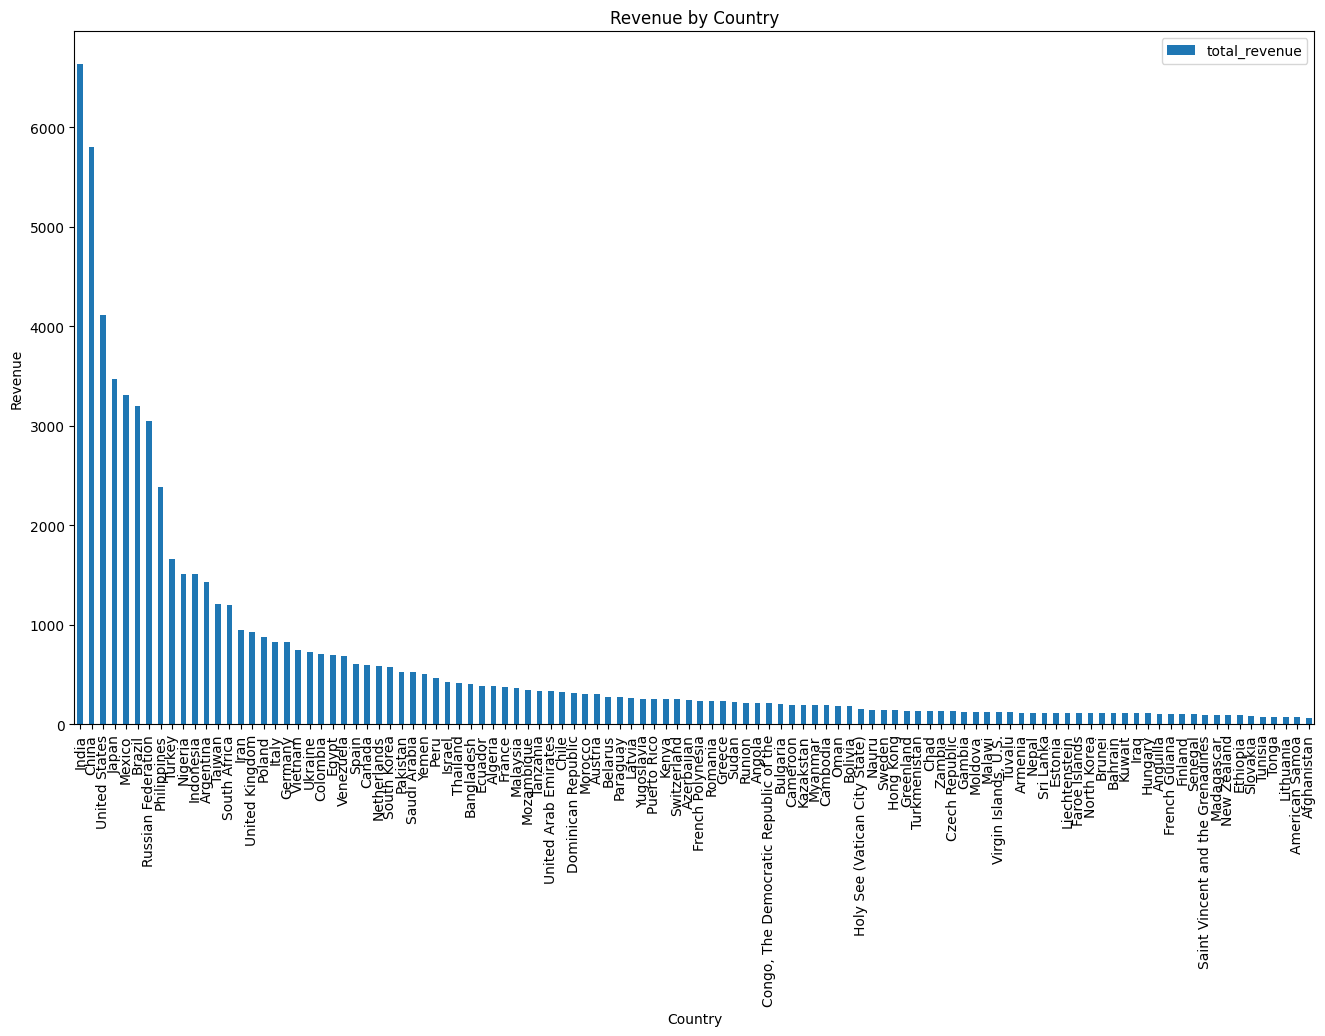

In [13]:
# reuse the dataframe in part 1

df_total_revenue.plot.bar(x='country', y='total_revenue')
plt.title('Revenue by Country')
plt.ylabel('Revenue')
plt.xlabel('Country')
plt.show()

### 4. Top 10 Actors by Revenue

In [14]:
query = """
SELECT a.first_name || ' ' || a.last_name as actor_name, SUM(p.amount) as total_revenue
FROM actor a
JOIN film_actor fa ON a.actor_id = fa.actor_id
JOIN inventory i ON i.film_id = fa.film_id
JOIN rental r ON r.inventory_id = i.inventory_id
JOIN payment p ON r.rental_id = p.rental_id
GROUP BY a.actor_id
ORDER BY total_revenue DESC
LIMIT 10
"""

df_top_actors = pd.read_sql(query, conn)
print(df_top_actors)

           actor_name  total_revenue
0      GINA DEGENERES        3442.49
1      MATTHEW CARREY        2742.19
2         MARY KEITEL        2689.25
3      SCARLETT DAMON        2655.28
4         WALTER TORN        2620.62
5  ANGELA WITHERSPOON        2614.46
6    CHRISTIAN AKROYD        2611.49
7         HENRY BERRY        2602.88
8       WOODY HOFFMAN        2546.40
9   CAMERON ZELLWEGER        2529.41


### 5. Country Classification Dataframe

Classify the country based on total revenue using Q1 and Q3, if the revenue is > Q3 than, it is classified to 'high' and so on

In [15]:
q1, q3 = np.percentile(df_total_revenue['total_revenue'], [25, 75])

In [16]:
conditions = [
    df_total_revenue['total_revenue'] > q3,
    df_total_revenue['total_revenue'] < q1
]

choices = ['High', 'Low']

# create new column revenue_classification
df_total_revenue['revenue_classification'] = np.select(conditions, choices, default='Medium')

In [17]:
# select only two columns
df_classification = df_total_revenue[['country', 'revenue_classification']]

df_classification

,country,revenue_classification
0,India,High
1,China,High
2,United States,High
3,Japan,High
4,Mexico,High
...,...,...
103,Tunisia,Low
104,Tonga,Low
105,Lithuania,Low
106,American Samoa,Low


In [18]:
# sample 20 countries

df_classification = df_classification.sample(20, replace=False, random_state=1)

df_classification

,country,revenue_classification
100,New Zealand,Low
90,Bahrain,Low
92,Iraq,Low
89,Brunei,Low
101,Ethiopia,Low
55,Romania,Medium
88,North Korea,Low
54,French Polynesia,Medium
48,Latvia,Medium
66,Oman,Medium


### 6. Merge country classification with other dataframe

In [19]:
# calculate the total revenue grouped by actor and their countries

query = """
SELECT
    a.first_name || ' ' || a.last_name AS actor_name,
    co.country,
    SUM(p.amount) AS total_revenue
FROM actor a
JOIN film_actor fa ON a.actor_id = fa.actor_id
JOIN inventory i ON fa.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
JOIN payment p ON r.rental_id = p.rental_id
JOIN customer c ON p.customer_id = c.customer_id
JOIN address ad ON c.address_id = ad.address_id
JOIN city ci ON ad.city_id = ci.city_id
JOIN country co ON ci.country_id = co.country_id
GROUP BY a.actor_id, co.country
ORDER BY total_revenue DESC, co.country, actor_name;
"""

df_actor_revenue = pd.read_sql(query, conn)
df_actor_revenue

,actor_name,country,total_revenue
0,GINA DEGENERES,India,368.21
1,ALBERT JOHANSSON,India,324.34
2,CAMERON ZELLWEGER,India,313.35
3,CHRISTIAN AKROYD,India,308.38
4,MATTHEW CARREY,India,295.23
...,...,...,...
16386,PENELOPE PINKETT,Zambia,0.99
16387,RENEE TRACY,Zambia,0.99
16388,SANDRA PECK,Zambia,0.99
16389,VIVIEN BASINGER,Cambodia,0.00


In [20]:
# left outer join on country column
pd.merge(df_actor_revenue, df_classification, how="left")

,actor_name,country,total_revenue,revenue_classification
0,GINA DEGENERES,India,368.21,NaN
1,ALBERT JOHANSSON,India,324.34,NaN
2,CAMERON ZELLWEGER,India,313.35,NaN
3,CHRISTIAN AKROYD,India,308.38,NaN
4,MATTHEW CARREY,India,295.23,NaN
...,...,...,...,...
16386,PENELOPE PINKETT,Zambia,0.99,NaN
16387,RENEE TRACY,Zambia,0.99,NaN
16388,SANDRA PECK,Zambia,0.99,NaN
16389,VIVIEN BASINGER,Cambodia,0.00,NaN
